In [84]:
# https://github.com/AntixK/PyTorch-VAE
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from sklearn import metrics
import time
import copy
import os
import random
from matplotlib import pyplot as plt
import glob 
from pathlib import Path
import PIL
import math
import sys
import torchvision.transforms as transforms
from collections import Counter
from abc import abstractmethod
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from typing import List, Optional, Sequence, Union, Any, Callable
import torch.nn.functional as F


import yaml
import argparse
import torch.backends.cudnn as cudnn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
# from dataset import VAEDataset
from pytorch_lightning.plugins import DDPPlugin
import pytorch_lightning as pl
import torchvision.utils as vutils
from torch import optim


In [85]:
exp_params = {
  'LR': 0.005,
  'weight_decay': 0.0,
  'scheduler_gamma': 0.95,
  'kld_weight': 0.00025,
  'manual_seed': 1265
}


class trainer_params:
  gpus: 1
  max_epochs: 100

In [86]:
class ENA(Dataset):

    def __init__(self, root, transform):
        if not isinstance(root, tuple): raise # FIX THIS WHY TUPLE....
        root = root[0]
        self.root = root
        self.transforms = transform
        self.ids = [os.path.split(i)[1].split('.jpg')[0] for i in glob.glob(root + '/*.jpg', recursive=True)]
        self.labelpath = Path(root).parent.parent / "labels" / Path(root).name

    def __getitem__(self, index):
        img_id = self.ids[index]

        imgname = img_id + '.jpg'

        with open(self.labelpath / (img_id + '.txt')) as f:
            target = f.readline()[0]
        assert (len(target)==1)
        target=int(target)
        #TODO Check if convert RGB makes sense for Grayscale
        img = Image.open(os.path.join(self.root, imgname)).convert('RGB')
        img = self.transforms(img)
        return img, target


    def __len__(self):
        return len(self.ids)


In [87]:
class VAEDataset(pl.LightningDataModule):
    """
    PyTorch Lightning data module 
    Args:
        data_dir: root directory of your dataset.
        train_batch_size: the batch size to use during training.
        val_batch_size: the batch size to use during validation.
        patch_size: the size of the crop to take from the original images.
        num_workers: the number of parallel workers to create to load data
            items (see PyTorch's Dataloader documentation for more details).
        pin_memory: whether prepared items should be loaded into pinned memory
            or not. This can improve performance on GPUs.
    """

    def __init__(
        self,
        train_dir: str,
        val_dir: str,
        test_dir: str,
        train_batch_size: int = 8,
        val_batch_size: int = 8,
        # patch_size: Union[int, Sequence[int]] = (256, 256),
        patch_size: int = 64, # Union[int, Sequence[int]] = (256, 256),
        num_workers: int = 0,
        pin_memory: bool = False,
        **kwargs,
    ):
        super().__init__()
        print('!WARNING: hardcoded size')
        self.train_dir = train_dir,
        self.val_dir = val_dir,
        self.test_dir = test_dir,        
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.patch_size = patch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

    def setup(self, stage: Optional[str] = None) -> None:
    
        train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            #   transforms.CenterCrop(148),
                                              transforms.Resize(self.patch_size),
                                              transforms.ToTensor(),])
        
        val_transforms = transforms.Compose([
                                            # transforms.CenterCrop(148),
                                            transforms.Resize(self.patch_size),
                                            transforms.ToTensor(),])
        
        self.train_dataset = ENA(
            self.train_dir,
            # split='train',
            transform=train_transforms,
            # download=False,
        )
        
        # Replace CelebA with your dataset
        self.val_dataset = ENA(
            self.val_dir,
            transform=val_transforms,
            # download=False,
        )

        self.test_dataset = ENA(
            self.test_dir,
            transform=val_transforms,
            # download=False,
        )
        
    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )

    def val_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.val_dataset,
            batch_size=self.val_batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=self.pin_memory,
        )
    
    def test_dataloader(self) -> Union[DataLoader, List[DataLoader]]:
        return DataLoader(
            self.test_dataset,
            batch_size=144,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=self.pin_memory,
        )
     

In [88]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

In [89]:
class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

In [188]:
class Encoder(nn.Module):
    def __init__(self,
        in_channels: int,
        latent_dim: int,
        hidden_dims = None,  
        **kwargs) -> None:
        super(Encoder, self).__init__()

        
        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                                kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 4, latent_dim)

    def forward(self, inp):
        result = self.encoder(inp)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

In [189]:
class VanillaVAE(BaseVAE):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.encoder = Encoder(in_channels, latent_dim, hidden_dims)

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        return self.encoder(input)


    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [190]:
class VAEXperiment(pl.LightningModule):

    def __init__(self,
                 vae_model: BaseVAE,
                 params: dict) -> None:
        super(VAEXperiment, self).__init__()

        self.model = vae_model
        self.params = params
        self.curr_device = None
        self.hold_graph = False
        try:
            self.hold_graph = self.params['retain_first_backpass']
        except:
            pass

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        return self.model(input, **kwargs)

    def training_step(self, batch, batch_idx, optimizer_idx = 0):
        real_img, labels = batch
        self.curr_device = real_img.device

        results = self.forward(real_img, labels = labels)
        train_loss = self.model.loss_function(*results,
                                              M_N = self.params['kld_weight'], #al_img.shape[0]/ self.num_train_imgs,
                                              optimizer_idx=optimizer_idx,
                                              batch_idx = batch_idx)

        self.log_dict({key: val.item() for key, val in train_loss.items()}, sync_dist=True)

        return train_loss['loss']

    def validation_step(self, batch, batch_idx, optimizer_idx = 0):
        real_img, labels = batch
        self.curr_device = real_img.device

        results = self.forward(real_img, labels = labels)
        val_loss = self.model.loss_function(*results,
                                            M_N = 1.0, #real_img.shape[0]/ self.num_val_imgs,
                                            optimizer_idx = optimizer_idx,
                                            batch_idx = batch_idx)

        self.log_dict({f"val_{key}": val.item() for key, val in val_loss.items()}, sync_dist=True)

        
    def on_validation_end(self) -> None:
        self.sample_images()
        
    def sample_images(self):
        # Get sample reconstruction image            
        test_input, test_label = next(iter(self.trainer.datamodule.test_dataloader()))
        test_input = test_input.to(self.curr_device)
        test_label = test_label.to(self.curr_device)

#         test_input, test_label = batch
        recons = self.model.generate(test_input, labels = test_label)
        Path(f"{self.logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)
        vutils.save_image(recons.data,
                          os.path.join(self.logger.log_dir , 
                                       "Reconstructions", 
                                       f"recons_{self.logger.name}_Epoch_{self.current_epoch}.png"),
                          normalize=True,
                          nrow=12)

        try:
            samples = self.model.sample(144,
                                        self.curr_device,
                                        labels = test_label)
            Path(f"{self.logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
            vutils.save_image(samples.cpu().data,
                              os.path.join(self.logger.log_dir , 
                                           "Samples",      
                                           f"{self.logger.name}_Epoch_{self.current_epoch}.png"),
                              normalize=True,
                              nrow=12)
        except Warning:
            pass

    def configure_optimizers(self):

        optims = []
        scheds = []

        optimizer = optim.Adam(self.model.parameters(),
                               lr=self.params['LR'],
                               weight_decay=self.params['weight_decay'])
        optims.append(optimizer)
        # Check if more than 1 optimizer is required (Used for adversarial training)
        try:
            if self.params['LR_2'] is not None:
                optimizer2 = optim.Adam(getattr(self.model,self.params['submodel']).parameters(),
                                        lr=self.params['LR_2'])
                optims.append(optimizer2)
        except:
            pass

        try:
            if self.params['scheduler_gamma'] is not None:
                scheduler = optim.lr_scheduler.ExponentialLR(optims[0],
                                                             gamma = self.params['scheduler_gamma'])
                scheds.append(scheduler)

                # Check if another scheduler is required for the second optimizer
                try:
                    if self.params['scheduler_gamma_2'] is not None:
                        scheduler2 = optim.lr_scheduler.ExponentialLR(optims[1],
                                                                      gamma = self.params['scheduler_gamma_2'])
                        scheds.append(scheduler2)
                except:
                    pass
                return optims, scheds
        except:
            return optims

In [191]:
LOG_DIR = './'
tb_logger =  TensorBoardLogger(save_dir=LOG_DIR,
                               name='lightning_logs',)

Path(f"{tb_logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
Path(f"{tb_logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)
model = VanillaVAE(3,128)
experiment = VAEXperiment(model,
                          exp_params)

In [192]:
runner = Trainer(callbacks=[
                     LearningRateMonitor(),
                     ModelCheckpoint(save_top_k=2, 
                                     dirpath =os.path.join(LOG_DIR , "checkpoints"), 
                                     monitor= "val_loss",
                                     save_last= True),
                 ],
                 gpus = 1, max_epochs=100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [193]:
# datamodule=VAEDataset(train_dir= 'C:/temp/ena/images/train100/', val_dir='C:/temp/ena/images/val/', test_dir='C:/temp/ena/images/test/')
datamodule=VAEDataset(train_dir= 'C:/temp/data_final/islands/images/ISL64xSeqRGBTrain5/', val_dir='C:/temp/data_final/islands/images/ISL64xSeqRGBVal20/', test_dir='C:/temp/data_final/islands/images/ISL64xSeqRGBTest20/')
datamodule.setup()
runner.fit(experiment, datamodule=datamodule)

!WARNING: hardcoded size


c:\Projects\pyvenvs\wildsenv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:611: UserWarning: Checkpoint directory C:\Projects\wild\models\VAE\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | VanillaVAE | 3.9 M 
-------------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.751    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Projects\pyvenvs\wildsenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Projects\pyvenvs\wildsenv\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [164]:
inp = next(iter(datamodule.train_dataloader()))[0]
res = model.forward(inp.to('cuda'))

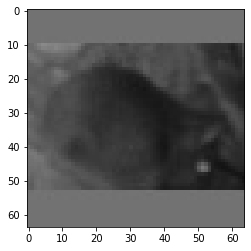

In [165]:
plt.imshow(inp[7].permute(1,2,0))

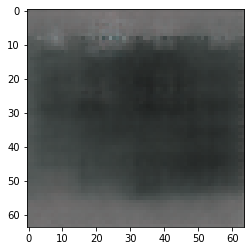

In [166]:
plt.imshow(res[0][7].cpu().permute(1,2,0).detach().numpy())

In [53]:
img = res[0][0].cpu().permute(1,2,0).detach().numpy()

In [51]:
res[0][0][0][0]

tensor([ 0.0005, -0.0037, -0.0023, -0.0038, -0.0036, -0.0028, -0.0026, -0.0042,
        -0.0026, -0.0028, -0.0031, -0.0034, -0.0030, -0.0041, -0.0031, -0.0028,
        -0.0029, -0.0041, -0.0030, -0.0030, -0.0036, -0.0044, -0.0027, -0.0034,
        -0.0029, -0.0038, -0.0029, -0.0032, -0.0033, -0.0042, -0.0026, -0.0030,
        -0.0029, -0.0033, -0.0027, -0.0031, -0.0032, -0.0040, -0.0026, -0.0030,
        -0.0032, -0.0034, -0.0026, -0.0032, -0.0035, -0.0040, -0.0026, -0.0036,
        -0.0036, -0.0034, -0.0020, -0.0030, -0.0033, -0.0040, -0.0023, -0.0036,
        -0.0025, -0.0019, -0.0012, -0.0024, -0.0032, -0.0033, -0.0030,  0.0020],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [52]:
import cv2

In [71]:
imgn = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

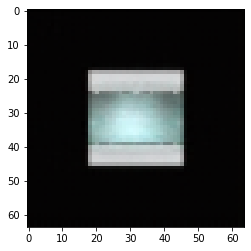

In [75]:
plt.imshow(imgn, aspect=1)

In [57]:
imgn.shape

(64, 64, 3)

In [58]:
# count black pixels in image: 
black_pixels = np.sum(imgn[:,:,0] == 0)

In [59]:
black_pixels

0

AttributeError: module 'cv2' has no attribute 'imsave'

True

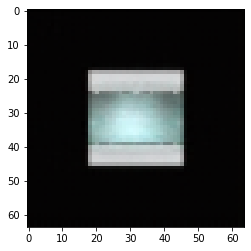

In [79]:
#save imgn:
plt.imshow(imgn, aspect=1)
cv2.imwrite('C:/temp/test.jpg', imgn*255)

In [177]:
model.encode(inp.to('cuda'))[0].shape

torch.Size([8, 128])